In [4]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
inception_pretrain_model_dir = 'inception_model'

logdir = 'logs'

if not os.path.exists(logdir):
    os.makedirs(logdir)

# inception_graph_def_file = os.path.join(inception_pretrain_model_dir, 'classify_image_graph_def.pb')
# with tf.Session() as sess:
#     with tf.gfile.FastGFile(inception_graph_def_file, 'rb') as f:
#         graph_def = tf.GraphDef()
#         graph_def.ParseFromString(f.read())
#         tf.import_graph_def(graph_def, name='')
#     writer = tf.summary.FileWriter(logdir, sess.graph)
#     writer.close()

images\cropped_panda.jpg


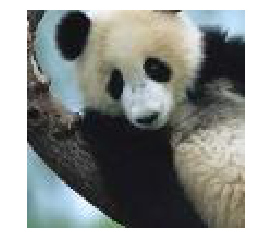

node_id is  169 , giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca  score is  0.896318
node_id is  75 , indri, indris, Indri indri, Indri brevicaudatus  score is  0.00766088
node_id is  7 , lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens  score is  0.00266421



In [14]:
class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        
    def load(self, label_lookup_path, uid_lookup_path):
        print('loading data......')
        # 加载分类字符串， 对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        for line in proto_as_ascii_lines:
            line = line.strip('\n')
            parsed_items = line.split('\t')
            uid = parsed_items[0]
            human_string = parsed_items[1]
            uid_to_human[uid] = human_string
            
        # 加载分类字符串， 对应分类编号1-1000的文件
        proto_as_ascii_lines = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii_lines:
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]
                
        node_id_to_name = {}
        for key,val in node_id_to_uid.items():
            name =  uid_to_human[val]
            node_id_to_name[key] = name
        
        return node_id_to_name
    
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]
    
# 创建一个图来存取google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def)
    
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')

    node_lookup = NodeLookup()
    # 遍历目录
    for root,dirs,files in os.walk('images'):
        for file in files:
            # 载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()
            predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})
            predictions = np.squeeze(predictions) #把二维结果转为1维数据
            
            image_path = os.path.join(root,file)
            print(image_path)
            
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
            #排序
            top_k = predictions.argsort()[-3:][::-1]
            for node_id in top_k:
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                print(human_string," score is ",score)
            print()

In [13]:
node_lookup = NodeLookup()
node_lookup.node_lookup

{}